In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf

In [35]:
df = pd.read_csv("monthly-beer-production-in-austr.csv")
df.columns = ['Date', 'Beers']

In [36]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by = "Date")

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.day_of_week

<Axes: xlabel='Date'>

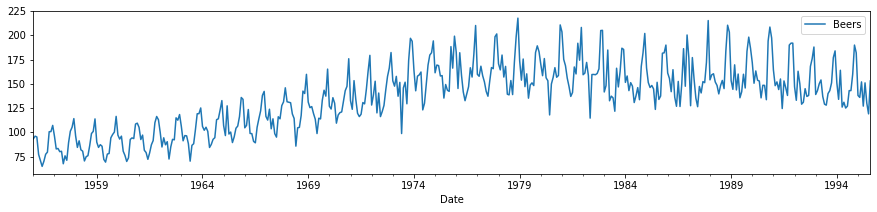

In [37]:
df.plot(x='Date', y='Beers', figsize=(15, 3))

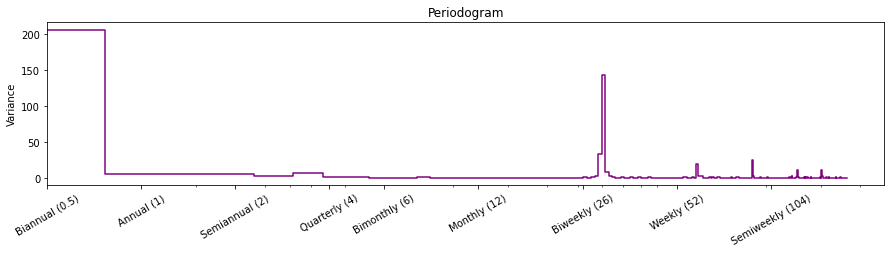

In [38]:
freqencies, spectrum = periodogram(
        df['Beers'],
        fs=730,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )

plt.figure(figsize=(15, 3))
plt.step(freqencies, spectrum, color="purple")
plt.xscale("log")
plt.xticks([1, 2, 4, 8, 12, 24, 52, 104, 208],
          [
        "Biannual (0.5)",
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)"
    ],rotation=30)
plt.ylabel("Variance")
plt.title("Periodogram")
plt.show()

In [39]:
dates = df['Date'].unique()
days = np.arange(1, len(dates)+1)
days = pd.DataFrame({"Date":dates, "Day":days})
df = df.merge(days, on="Date", how="left")

In [49]:
df['Trend'] = (df['Day'])**3

In [41]:
Seasonality = dict(zip(
    (3.5, 7, 14, 365, 730, 1095),
    ('Semiweek', 'Week', 'Biweek', 'Annual', 'BiAnnual', 'TriAnnual')
))

for s, n in Seasonality.items():
    df[f'sin_{n}'] = np.sin(df['Day'] * (2*np.pi / s))
    df[f'cos_{n}'] = np.cos(df['Day'] * (2*np.pi / s))

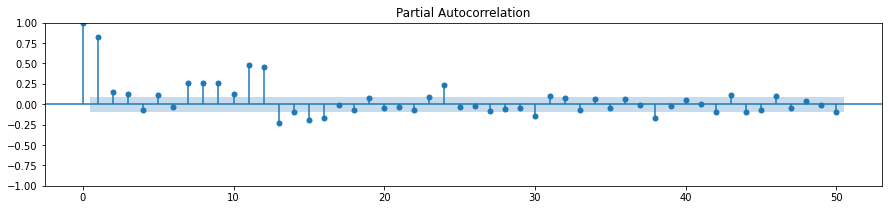

In [42]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
plot_pacf(df['Beers'], lags=50, ax=ax)
plt.show()

In [43]:
lags = [1,2,3,7,8,9,11,12,13,15,16,24,30,38]
lagged = pd.concat({
    f'lag_{lag}': df['Beers'].shift(lag) for lag in lags
}, axis=1)

In [44]:
df = pd.concat([df, lagged], axis=1).dropna()
df = df.set_index("Date")

In [50]:
X = df.drop(columns = "Beers")
y = df['Beers']

from sklearn.preprocessing import StandardScaler

features = X.columns.values
dates = X.index.values

Scaler = StandardScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X, columns=features, index=dates)


n = len(X)
X_train = X[:int(0.7*n)]
y_train = y[:int(0.7*n)]
X_valid = X[int(0.7*n):]
y_valid = y[int(0.7*n):]

In [57]:
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

model = Lasso()
model.fit(X_train, y_train)

print("Training error: ", model.score(X_train, y_train))
print("Test error: ", model.score(X_valid, y_valid))

Training error:  0.9058755804725137
Test error:  0.7267381350036778


In [58]:
y_pred = pd.Series(model.predict(X_valid), index = X_valid.index)

<Axes: xlabel='Date'>

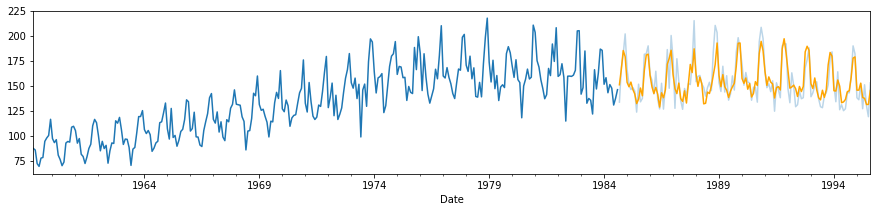

In [59]:
ax = y_train.plot(figsize=(15, 3), c='tab:blue')
y_valid.plot(ax = ax, c='tab:blue', alpha=0.3)
y_pred.plot(ax=ax, c='orange')